# Predict gross national income per capita
<br>
Prediction of gross netto income (GNI) per capita using global health data (here only mortality and tuberculosis data) collected yearly from 1960 to 2015.<br>
Hypothesis:Infant and child mortality will be a good indicators to predict GNI.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from IPython.display import display

pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_csv("Tuberculosis.csv", encoding="ISO-8859-1")
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Arab World,ARB,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,nan,nan,nan,nan,nan,nan,...,4091.430,4708.275,5516.011,5599.283,5822.417,6068.124,7024.380,7523.870,7540.196,7060.620
1,Arab World,ARB,"Incidence of tuberculosis (per 100,000 people)",SH.TBS.INCD,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,Arab World,ARB,"Mortality rate, adult, female (per 1,000 femal...",SP.DYN.AMRT.FE,298.939,295.215,291.265,286.360,281.529,276.840,...,134.710,132.588,130.304,128.074,125.903,123.819,121.763,120.239,118.743,nan
3,Arab World,ARB,"Mortality rate, adult, male (per 1,000 male ad...",SP.DYN.AMRT.MA,357.687,353.232,348.695,343.991,339.288,334.611,...,185.719,183.040,181.002,179.094,177.300,175.477,173.545,171.446,169.507,nan
4,Arab World,ARB,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,159.950,155.314,152.233,156.522,152.167,148.068,...,36.906,35.721,34.528,33.353,32.282,31.235,30.334,29.464,28.684,27.983


# Exploring the data

## How many variables do I have? How many datapoints?

In [3]:
print('Countries:\n', df['Country Code'].unique())
print('Total number of countries:\n', len(df['Country Code'].unique()))
print('Variables:\n', df['Indicator Name'].unique())
print('Data from',df.columns[4], 'till',df.columns[len(df.columns)-1], 'was collected.')

Countries:
 ['ARB' 'CSS' 'CEB' 'EAR' 'EAS' 'EAP' 'TEA' 'EMU' 'ECS' 'ECA' 'TEC' 'EUU'
 'FCS' 'HPC' 'HIC' 'LTE' 'LCN' 'LAC' 'TLA' 'LDC' 'LMY' 'LIC' 'LMC' 'MEA'
 'MNA' 'TMN' 'MIC' 'NAC' 'OED' 'OSS' 'PSS' 'PST' 'PRE' 'SST' 'SAS' 'TSA'
 'SSF' 'SSA' 'TSS' 'UMC' 'WLD' 'AFG' 'ALB' 'DZA' 'ASM' 'ADO' 'AGO' 'ATG'
 'ARG' 'ARM' 'ABW' 'AUS' 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL'
 'BLZ' 'BEN' 'BMU' 'BTN' 'BOL' 'BIH' 'BWA' 'BRA' 'VGB' 'BRN' 'BGR' 'BFA'
 'BDI' 'CPV' 'KHM' 'CMR' 'CAN' 'CYM' 'CAF' 'TCD' 'CHI' 'CHL' 'CHN' 'COL'
 'COM' 'ZAR' 'COG' 'CRI' 'CIV' 'HRV' 'CUB' 'CUW' 'CYP' 'CZE' 'DNK' 'DJI'
 'DMA' 'DOM' 'ECU' 'EGY' 'SLV' 'GNQ' 'ERI' 'EST' 'ETH' 'FRO' 'FJI' 'FIN'
 'FRA' 'PYF' 'GAB' 'GMB' 'GEO' 'DEU' 'GHA' 'GIB' 'GRC' 'GRL' 'GRD' 'GUM'
 'GTM' 'GIN' 'GNB' 'GUY' 'HTI' 'HND' 'HKG' 'HUN' 'ISL' 'IND' 'IDN' 'IRN'
 'IRQ' 'IRL' 'IMY' 'ISR' 'ITA' 'JAM' 'JPN' 'JOR' 'KAZ' 'KEN' 'KIR' 'PRK'
 'KOR' 'KSV' 'KWT' 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO' 'LBR' 'LBY' 'LIE' 'LTU'
 'LUX' 'MAC' 'MKD' 'MDG' 'MWI' 'MYS' 'M

## How much data is missing?

In [4]:
#Make a dataframe
dfs = pd.melt(df, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
dfs = dfs.rename(index=str,columns={"variable": "Year"})

# how much data is missig
#Total number of data points
tdp= dfs[dfs['Indicator Name'] == df['Indicator Name'].unique()[0]]['Country Name'].count() #totalnumber of datapoints
x=0
for i in df['Indicator Name'].unique():
    indi=df['Indicator Name'].unique()[x]
    print (indi)
    pdcomplete = (dfs[dfs['Indicator Name'] == indi]['value'].count())/tdp # This should only count cells that have data not nans
    print ('Percent complete data:', round(pdcomplete*100,2),"%")
    print()
    x=x+1

GNI per capita, Atlas method (current US$)
Percent complete data: 66.3 %

Incidence of tuberculosis (per 100,000 people)
Percent complete data: 38.91 %

Mortality rate, adult, female (per 1,000 female adults)
Percent complete data: 88.01 %

Mortality rate, adult, male (per 1,000 male adults)
Percent complete data: 88.01 %

Mortality rate, infant (per 1,000 live births)
Percent complete data: 80.52 %

Mortality rate, under-5 (per 1,000)
Percent complete data: 80.52 %

Prevalence of tuberculosis (per 100,000 population)
Percent complete data: 38.91 %

Tuberculosis case detection rate (all forms)
Percent complete data: 36.61 %

Tuberculosis death rate (per 100,000 people)
Percent complete data: 38.91 %

Tuberculosis treatment success rate (% of new cases)
Percent complete data: 25.94 %



In [5]:
# Remove nans
dfs = dfs.dropna()
dfs.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,value
2,Arab World,ARB,"Mortality rate, adult, female (per 1,000 femal...",SP.DYN.AMRT.FE,1960,298.939
3,Arab World,ARB,"Mortality rate, adult, male (per 1,000 male ad...",SP.DYN.AMRT.MA,1960,357.687
4,Arab World,ARB,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,1960,159.950
5,Arab World,ARB,"Mortality rate, under-5 (per 1,000)",SH.DYN.MORT,1960,249.360
12,Caribbean small states,CSS,"Mortality rate, adult, female (per 1,000 femal...",SP.DYN.AMRT.FE,1960,201.476


In [6]:
# select data for 2014
dfs1=dfs[dfs['Year']=='2014']
dfs1.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,value
139320,Arab World,ARB,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,2014,7540.196
139322,Arab World,ARB,"Mortality rate, adult, female (per 1,000 femal...",SP.DYN.AMRT.FE,2014,118.743
139323,Arab World,ARB,"Mortality rate, adult, male (per 1,000 male ad...",SP.DYN.AMRT.MA,2014,169.507
139324,Arab World,ARB,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,2014,28.684
139325,Arab World,ARB,"Mortality rate, under-5 (per 1,000)",SH.DYN.MORT,2014,37.789


## Do any of my variables have a known probability distribution (normal, Poisson, Gamma, etc)?

In [7]:
print('Distributions used:')
print('GNI: Generalized lognormal or pareto')
print('Incidence: binomial,poisson or exponential')
print('Mortality rates: negative binomial distribution and its continuous analog, the gamma distribution, show instability under right-censoring... distribution derived from the Richards generalization of the von Bertalanffy function')
#https://academic.oup.com/forestscience/article-abstract/31/2/331/4656994?redirectedFrom=PDF
print('Prevalene of disease, case detection rate, success rate: Unknown')

Distributions used:
GNI: Generalized lognormal or pareto
Incidence: binomial,poisson or exponential
Mortality rates: negative binomial distribution and its continuous analog, the gamma distribution, show instability under right-censoring... distribution derived from the Richards generalization of the von Bertalanffy function
Prevalene of disease, case detection rate, success rate: Unknown


## How much variance is there in each of my variables? 

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


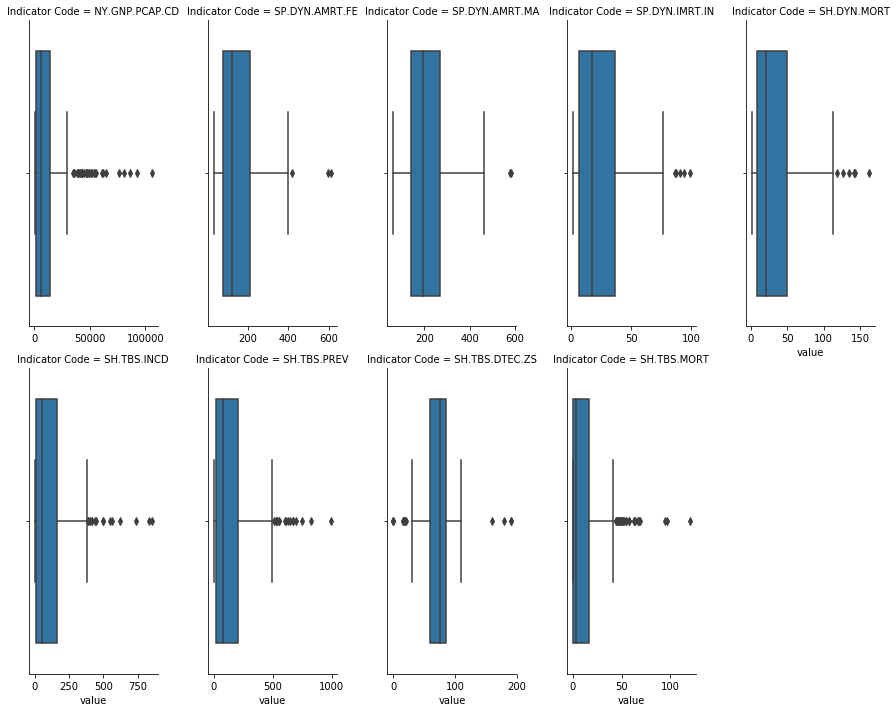

In [8]:
g = sns.FacetGrid(dfs1, col="Indicator Code", sharey=False,sharex=False, col_wrap=5, size=5, aspect=.5)
g = g.map(sns.boxplot, "value")
plt.show()

In [9]:
# Exclude countries with GNI above 50000
# Transform from skinny into wide format
cdf = dfs1.pivot_table(index=['Country Code'], columns=['Indicator Code'],values='value').reset_index().rename_axis(None, axis=1)
print(cdf.shape)
print(cdf.head())
cdf1= cdf[cdf['NY.GNP.PCAP.CD']<50000]
print(cdf1.shape)

# Make new skinny dataframe


(253, 10)
  Country Code  NY.GNP.PCAP.CD  SH.DYN.MORT  SH.TBS.DTEC.ZS  SH.TBS.INCD  \
0          ABW             nan          nan          18.000       11.000   
1          ADO             nan        2.900          89.000        9.200   
2          AFG         670.000       93.900          53.000      189.000   
3          AGO        4800.000      162.200          60.000      370.000   
4          ALB        4450.000       14.400          75.000       19.000   

   SH.TBS.MORT  SH.TBS.PREV  SP.DYN.AMRT.FE  SP.DYN.AMRT.MA  SP.DYN.IMRT.IN  
0        0.900       14.000          72.747         117.007             nan  
1        0.760       12.000             nan             nan           2.100  
2       44.000      340.000         238.105         281.270          68.100  
3       52.000      490.000         320.788         369.298          98.800  
4        0.580       26.000          50.325          85.266          12.900  
(210, 10)


## Exploring the data: Bivariate

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


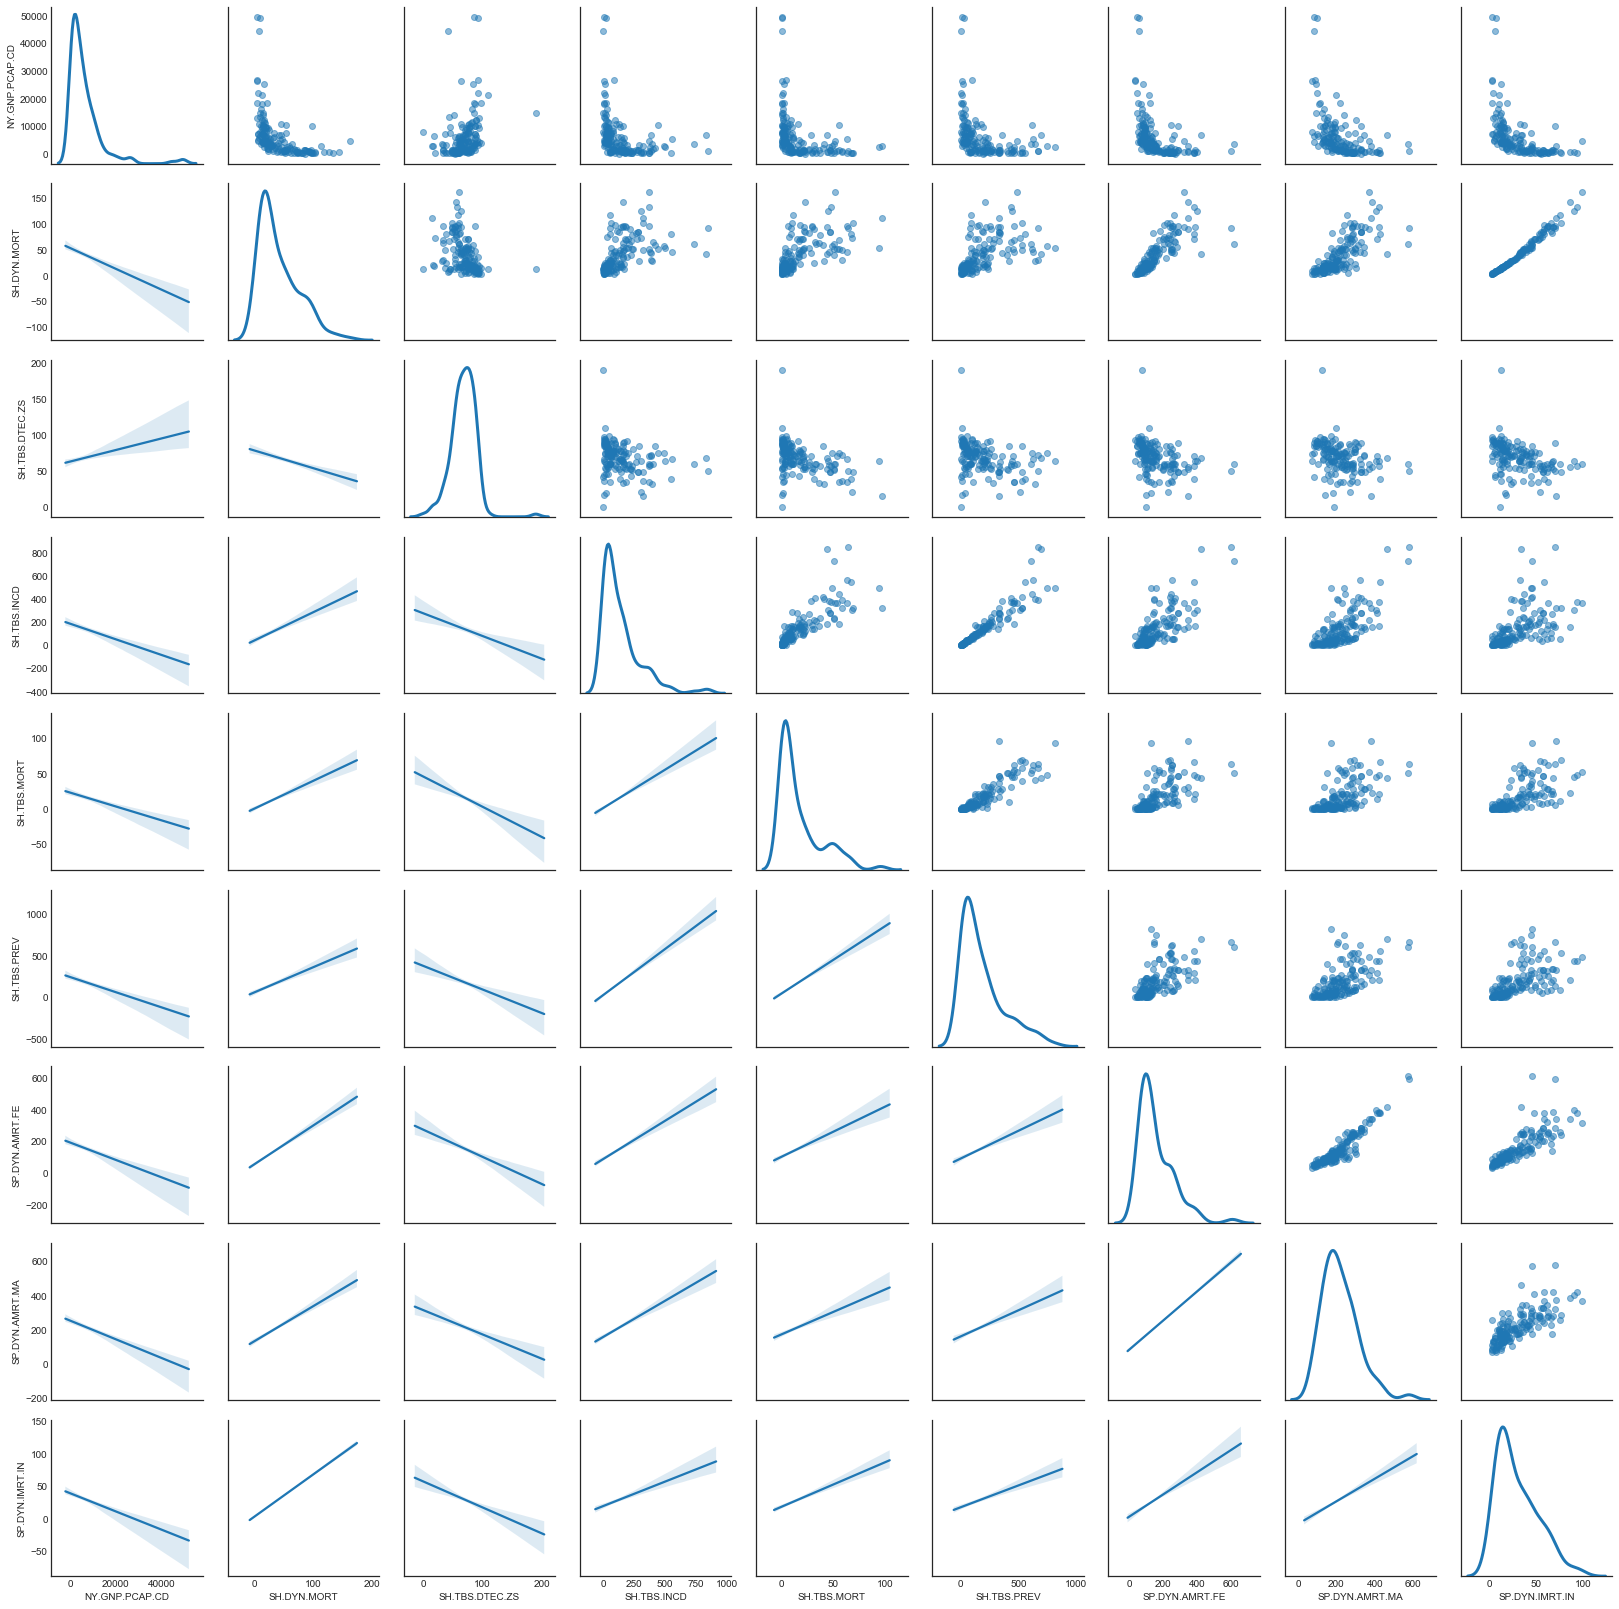

In [10]:
# Make the scatterplot matrix
# Set the default plot aesthetics to be prettier.
sns.set_style("white")

# cast the variables out

# Make a scatterplot matrix.
g = sns.PairGrid(cdf1.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

# New features

## Feature engineering

In [11]:
# Removing all remaining countries that have nans
print(cdf1.shape)
cdf2 = cdf1.drop(columns=['Country Code']).dropna()
print(cdf2.shape)

(210, 10)
(154, 9)


In [12]:

# Take original features
Features=cdf2
#Adding reversed variables
Features['TB_notdetected']= 100-cdf2['SH.TBS.DTEC.ZS']
Features['IN_survival']= 1000 - cdf2['SP.DYN.IMRT.IN']
Features['Child_survival']= 1000 - cdf2['SH.DYN.MORT']

#Features['GNI'] = cdf['NY.GNP.PCAP.CD']
Features['log_GNI']=np.log(cdf2['NY.GNP.PCAP.CD'])
Features['log_SH.DYN.MORT']=np.log(cdf2['SH.DYN.MORT'])
Features['log_SP.DYN.AMRT.FE']=np.log(cdf2['SP.DYN.AMRT.FE'])
Features['log_SP.DYN.AMRT.MA']=np.log(cdf2['SP.DYN.AMRT.MA'])
Features['log_SP.DYN.IMRT.IN']=np.log(cdf2['SP.DYN.IMRT.IN'])

# Normalize features to
#Normalize features
cols= list(Features.columns)
for col in cols:
    sc_col = 'sc_'+ col
    Features[sc_col] = (Features[col] - Features[col].mean())/Features[col].std(ddof=0)
#print(Features.head())


#Combining features
#Combining TB features
Features['TB_INC_MORT_PREV_sc']=Features[['sc_SH.TBS.INCD','sc_SH.TBS.MORT','sc_SH.TBS.PREV']].mean(axis=1)
#Combining adult and child mortality features
Features['POP_MORT_sc']=Features[['sc_SP.DYN.AMRT.FE','sc_SP.DYN.AMRT.MA','sc_SP.DYN.IMRT.IN', 'sc_SH.DYN.MORT']].mean(axis=1)
#Combining child and infant mortality features
Features['KID_MORT']=Features[['sc_SP.DYN.IMRT.IN', 'sc_SH.DYN.MORT']].mean(axis=1)
Features['KID_SURV']=Features[['sc_IN_survival', 'sc_Child_survival']].mean(axis=1)

# Combining feature features
Features['TB_ALL']=Features[['TB_INC_MORT_PREV_sc','sc_TB_notdetected']].mean(axis=1)

print(Features.head())

   NY.GNP.PCAP.CD  SH.DYN.MORT  SH.TBS.DTEC.ZS  SH.TBS.INCD  SH.TBS.MORT  \
2         670.000       93.900          53.000      189.000       44.000   
3        4800.000      162.200          60.000      370.000       52.000   
4        4450.000       14.400          75.000       19.000        0.580   
6       44640.000        7.100          42.000        1.600        0.320   
7       12330.000       12.900          89.000       24.000        1.400   

   SH.TBS.PREV  SP.DYN.AMRT.FE  SP.DYN.AMRT.MA  SP.DYN.IMRT.IN  \
2      340.000         238.105         281.270          68.100   
3      490.000         320.788         369.298          98.800   
4       26.000          50.325          85.266          12.900   
6        2.700          57.365          81.341           6.100   
7       30.000          75.142         153.684          11.500   

   TB_notdetected   ...    sc_log_GNI  sc_log_SH.DYN.MORT  \
2          47.000   ...        -1.418               1.312   
3          40.000   ... 

## PCA

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [6.91645508e-01 9.74223049e-02 8.58407120e-02 4.82310677e-02
 4.23788645e-02 1.15960713e-02 7.72612955e-03 6.82775607e-03
 4.65799528e-03 1.99650657e-03 8.61419215e-04 6.26428240e-04
 1.50904659e-04 3.83321918e-05 5.39533497e-32 2.29406664e-32
 3.70387756e-33 3.70387756e-33 3.70387756e-33 3.70387756e-33
 3.70387756e-33 3.70387756e-33 3.70387756e-33 3.70387756e-33
 3.70387756e-33 3.70387756e-33 3.70387756e-33 3.70387756e-33
 3.70387756e-33 3.70387756e-33 3.70387756e-33 3.70387756e-33
 3.70387756e-33 3.70387756e-33 3.70387756e-33 3.70387756e-33
 3.70387756e-33 2.19938344e-33 3.98997970e-34]


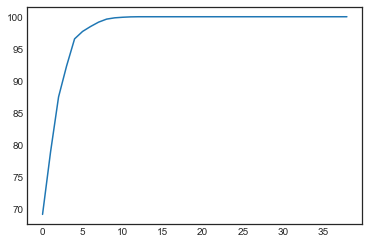

In [13]:
# Select principal components that describe the data best
from matplotlib.mlab import PCA as mlabPCA
from sklearn.decomposition import PCA 


# Normalize the data so that all variables have a mean of 0 and standard deviation
X = StandardScaler().fit_transform(cdf2)

# Transform X into Y.
sklearn_pca = PCA(n_components=X.shape[1])# X.shape[1] = number of columns
#From a couple of cells above
Y_sklearn = sklearn_pca.fit_transform(X) # Makes the whole PCA # Why do we have do to fit_transform twice??
#print(Y_sklearn)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

var1=np.cumsum(np.round(sklearn_pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(var1)

In [14]:
# looking at the above plot and variance values, I chose to continue with 6 principal components
pca_f = PCA(n_components=5)
pca_f_sklearn = pca_f.fit_transform(X)

PCA_Features = pd.DataFrame(pca_f_sklearn, index=cdf2.index, columns=['pca_1','pca_2','pca_3','pca_4','pca_5'])

## Feature testing

                       NY.GNP.PCAP.CD  sc_NY.GNP.PCAP.CD  log_GNI
sc_log_SH.DYN.MORT             -0.633             -0.633   -0.779
log_SH.DYN.MORT                -0.633             -0.633   -0.779
pca_1                          -0.610             -0.610   -0.775
sc_log_SP.DYN.IMRT.IN          -0.645             -0.645   -0.770
log_SP.DYN.IMRT.IN             -0.645             -0.645   -0.770
sc_SP.DYN.IMRT.IN              -0.511             -0.511   -0.730
SP.DYN.IMRT.IN                 -0.511             -0.511   -0.730
KID_MORT                       -0.498             -0.498   -0.724
SH.DYN.MORT                    -0.483             -0.483   -0.714
sc_SH.DYN.MORT                 -0.483             -0.483   -0.714
sc_log_SP.DYN.AMRT.FE          -0.567             -0.567   -0.703
log_SP.DYN.AMRT.FE             -0.567             -0.567   -0.703
POP_MORT_sc                    -0.505             -0.505   -0.695
log_SP.DYN.AMRT.MA             -0.569             -0.569   -0.631
sc_log_SP.

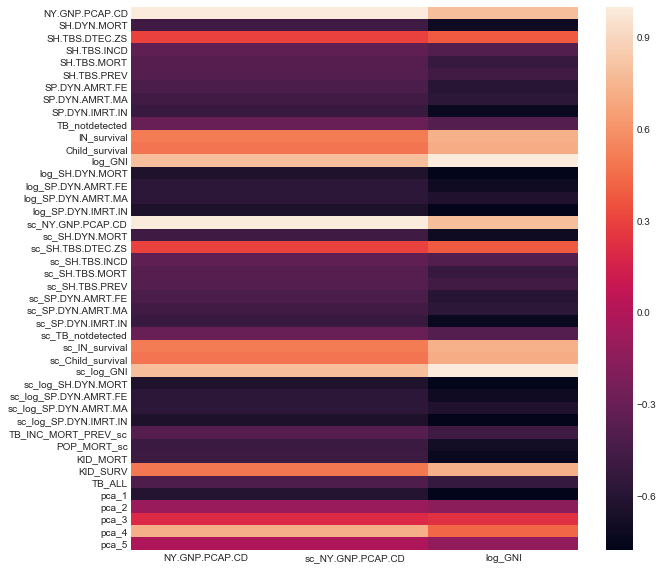

In [15]:
#Combine data with features and pca features
Alldata = pd.concat([Features, PCA_Features], axis=1, sort=False)

# See which features correlate best with GNI variables
CorrMa = Alldata.corr(method='pearson')
print(CorrMa[['NY.GNP.PCAP.CD','sc_NY.GNP.PCAP.CD','log_GNI']].sort_values(by=['log_GNI']))
#print(CorrMa[['NY.GNP.PCAP.CD','sc_NY.GNP.PCAP.CD','log_GNI']].sort_values(by=['log_GNI']).tail(5))

plt.figure(figsize=(10,10))
sns.heatmap(CorrMa[['NY.GNP.PCAP.CD','sc_NY.GNP.PCAP.CD','log_GNI']])

# plotting the correlation between the variables and the generated feature
# increase plot and not decrease font size font_scale=1.5
plt.show()

In [16]:
# Best Features by correlation are:
CorrMa['log_GNI_ABS']=abs(CorrMa['log_GNI'])
#CorrMa[['log_GNI','log_GNI_ABS']].head()
CorrMaSorted=CorrMa.sort_values(by=['log_GNI_ABS'], ascending=False)
print (CorrMaSorted['log_GNI_ABS'].head(20))

sc_log_GNI              1.000
log_GNI                 1.000
NY.GNP.PCAP.CD          0.788
sc_NY.GNP.PCAP.CD       0.788
sc_log_SH.DYN.MORT      0.779
log_SH.DYN.MORT         0.779
pca_1                   0.775
sc_log_SP.DYN.IMRT.IN   0.770
log_SP.DYN.IMRT.IN      0.770
sc_IN_survival          0.730
IN_survival             0.730
sc_SP.DYN.IMRT.IN       0.730
SP.DYN.IMRT.IN          0.730
KID_MORT                0.724
KID_SURV                0.724
Child_survival          0.714
SH.DYN.MORT             0.714
sc_Child_survival       0.714
sc_SH.DYN.MORT          0.714
sc_log_SP.DYN.AMRT.FE   0.703
Name: log_GNI_ABS, dtype: float64


# Modeling


## Select data for modeling

In [17]:
target = Alldata['log_GNI']
data = Alldata[['sc_log_SH.DYN.MORT','pca_1','sc_log_SP.DYN.IMRT.IN','sc_IN_survival','sc_Child_survival']]

## OLS


Coefficients: 
 [-2.30156029 -0.09731144  1.61336461  0.33267152 -0.63553298]

Intercept: 
 8.146127911596098

R-squared: 
 0.6316583409050495


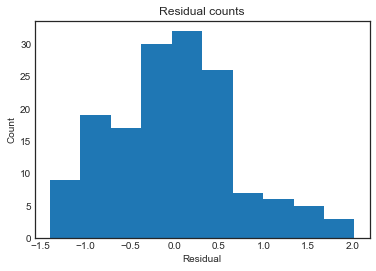

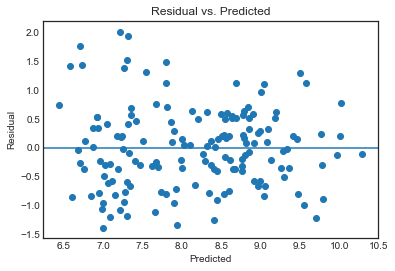

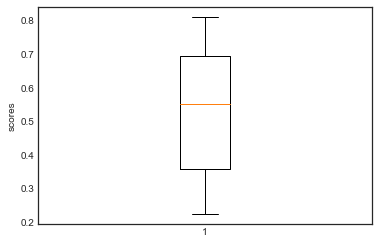

In [18]:
# Instantiate and fit model for outlier-corrected data
regr = linear_model.LinearRegression()

regr.fit(data, target)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(data, target))
# Extract predicted values.
predicted = regr.predict(data).ravel()
actual = Alldata['log_GNI']

# Calculate the error, also called the residual.
residual = actual - predicted

#Check the -6000 outlier
#Alldata['residuals']=residual
#print(Alldata.sort_values(by=['residuals']).head())

# Error histogram
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Error scatter plot
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# cross validation
score_OLS = cross_val_score(regr, data, target, cv=20)

#
plt.boxplot(score_OLS)
plt.ylabel('scores')
plt.show()

### Optimizing OLS 

In [19]:
# statistical analysis of model
# Combine normalized data and data

#Alldata[['sc_log_SH.DYN.MORT','pca_1','sc_log_SP.DYN.IMRT.IN','sc_IN_survival','sc_Child_survival']]

combidata = Alldata[['log_GNI','sc_log_SH.DYN.MORT','pca_1','sc_log_SP.DYN.IMRT.IN','sc_IN_survival','sc_Child_survival']]
combidata= combidata.rename(index=str, columns={"sc_log_SH.DYN.MORT": "sc_log_SH_DYN_MORT", "sc_log_SP.DYN.IMRT.IN": "sc_log_SP_DYN_IMRT_IN"})                          
               
#print(combidata.head())
linear_formula= 'log_GNI~sc_log_SH_DYN_MORT+pca_1+sc_log_SP_DYN_IMRT_IN+sc_IN_survival+sc_Child_survival'
lm= smf.ols(formula=linear_formula, data= combidata).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                log_GNI   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     50.76
Date:                Tue, 24 Jul 2018   Prob (F-statistic):           1.99e-30
Time:                        12:30:50   Log-Likelihood:                -163.88
No. Observations:                 154   AIC:                             339.8
Df Residuals:                     148   BIC:                             358.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.14

The statistical analysis shows, that the F-test of the model results in a significant p-value, but none of the variables itself is significant.<br>
When trying them all individually:<br>
sc_log_SH_DYN_MORT: p < 0.05 R^2 = 0.606<br>
pca_1: p<0.05 R^2 =0.60<br>
sc_log_SP_DYN_IMRT_IN : p<0.05 R^2 = 0.59<br>
sc_IN_survival: p<0.05, R^2 = 0.53<br>
sc_Child_survival: p<0.05 R^2 = 0.51<br>
<br>
Combining the strongest two:<br>
sc_log_SH_DYN_MORT+pca_1: both features have significant p-values,  R^2=0.623<br>
<br>
Combining the strongest three: the features don't have significant p-values anymore, R^2= 0.624 only slightly better.
Concluding from this, I chose a simpler model:<br>
$$ GNI = \alpha + sc.log.SH.DYN.MORT + pca.1$$


Coefficients: 
 [-0.49940126 -0.08227958]

Intercept: 
 8.1461279115961

R-squared: 
 0.6229293221127996


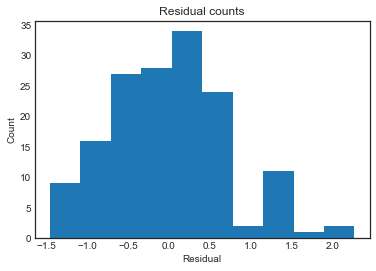

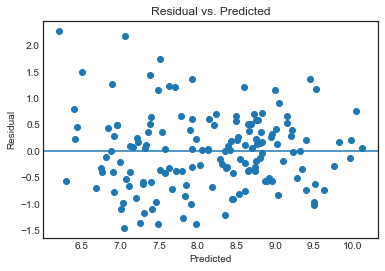

In [20]:
target = Alldata['log_GNI']
newdata = Alldata[['sc_log_SH.DYN.MORT','pca_1']]
# Instantiate and fit model for outlier-corrected data
regr = linear_model.LinearRegression()

regr.fit(newdata, target)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(newdata, target))
# Extract predicted values.
predicted = regr.predict(newdata).ravel()
actual = Alldata['log_GNI']

# Calculate the error, also called the residual.
residual = actual - predicted

# Error histogram
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Error scatter plot
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# cross validation
score_OLS_opt = cross_val_score(regr, newdata, target, cv=20)

Optimization of the model does not improve the score.

## KNN

In [21]:
# Get data
X = Alldata[['sc_log_SH.DYN.MORT','pca_1','sc_log_SP.DYN.IMRT.IN','sc_IN_survival','sc_Child_survival']]
Y = Alldata['log_GNI']
newX = Alldata[['sc_log_SH.DYN.MORT','pca_1']]

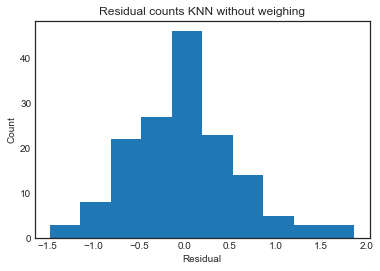

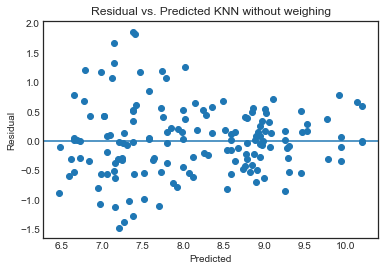

In [22]:
from sklearn import neighbors
from scipy import stats

# Build model without weighing 
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X, Y)

# Error plotting for KNN
predicted = knn.predict(X).ravel()
actual = Alldata['log_GNI']

# Calculate the error, also called the residual.
residual = actual - predicted

# Error histogram
plt.hist(residual)
plt.title('Residual counts KNN without weighing')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Error scatter plot
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted KNN without weighing')
plt.show()

# cross validation
score_KNN = cross_val_score(knn, X, target, cv=20)

In [23]:
# Get data
X = Alldata[['sc_log_SH.DYN.MORT','pca_1','sc_log_SP.DYN.IMRT.IN','sc_IN_survival','sc_Child_survival']]
Y = Alldata['log_GNI']
newX = Alldata[['sc_log_SH.DYN.MORT','pca_1']]

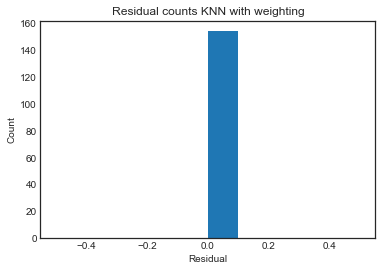

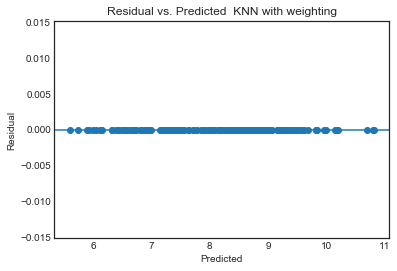

In [33]:
# Fit Model with weighing
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_w.fit(X, Y)

# Error plotting for KNN_W
pre = knn_w.predict(X).ravel()
act = Alldata['log_GNI']

# Calculate the error, also called the residual.
res = act - pre

# Error histogram
plt.hist(res)
plt.title('Residual counts KNN with weighting')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Error scatter plot
plt.scatter(pre, res)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted  KNN with weighting')
plt.show()

# cross validation
score_KNN_w = cross_val_score(knn_w, X, target, cv=2)

# Result

Text(0.5,0,'Models tried')

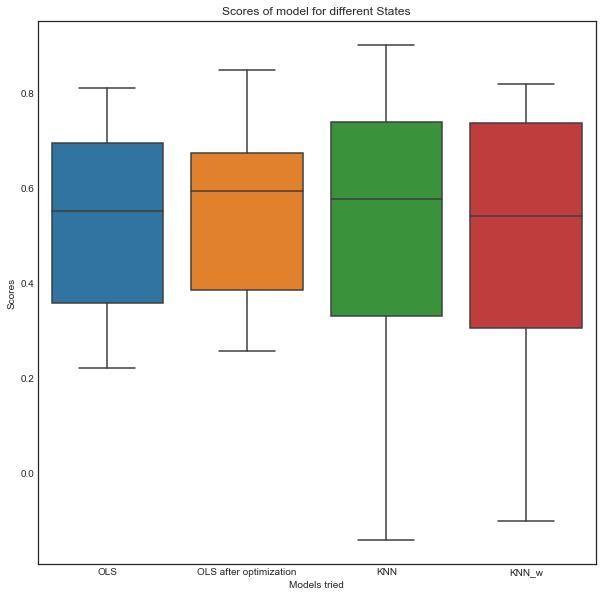

In [25]:
Scores = {'OLS': score_OLS, 'OLS after optimization': score_OLS_opt, 'KNN': score_KNN,'KNN_w': score_KNN_w}
results = pd.DataFrame(data=Scores)

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im = sns.boxplot(data=results, ax=ax)
im.set_title('Scores of model for different States')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')

Comparing the performance of ordinary least squares regression and k-nearest neighbor regression, both models return similar scores of around 0.6. However, for OLS the standard deviation is a smaller, therefore I would choose OLS.

I think OLS outperforms KNN here, because it is less sensitive to noise. As k is set to a certain number, it will use this number of neighbors no matter how far apart thes neighbors are from the data to pedict. KNN will work well for areas where the data is densly populated, but in areas with only a few data spots, the predicted value is less precise because too many far apart datapoints were taken into consideration.Linear regression assumes a linear relationship, if the data is far from linear the model will result in poor predictions. For KNN the relation ship of the data is not limited to linear relationships, it should outperfom OLS in those cases.